## 数据导入

In [1]:
import numpy as np
import os
import gzip
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_file = gzip.open(os.path.join(os.curdir, "datasets", "mnist.pkl.gz"), "rb")
train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
data_file.close()

In [4]:
def vectorize(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

train_X = [np.reshape(x, (784, 1)) for x in train_data[0]]
train_y = [vectorize(y) for y in train_data[1]]
train_data = list(zip(train_X, train_y))

val_X = [np.reshape(x, (784, 1)) for x in val_data[0]]
val_y = [vectorize(y) for y in val_data[1]]
val_data = list(zip(val_X, val_y))

test_X = [np.reshape(x, (784, 1)) for x in test_data[0]]
test_y = [vectorize(y) for y in test_data[1]]
test_data = list(zip(test_X, test_y))

##  激活函数

In [5]:
def relu(x):
    return np.maximum(0,x)
def relu_gradient(x):
    return np.where(x>0,1,0.01)

def softmax(x):
    exp = np.exp(x-np.max(x))
    return exp/exp.sum()
def softmax_gradient(x,y):
    return x-y

def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_gradient(x):
    return sigmoid(x) * (1-sigmoid(x))

## Network构建

In [6]:
class NeuralNetwork:
    
    def __init__(self, sizes): #初始化神经网络
        
        self.sizes = sizes
        self.num_layers = len(sizes)
        # 初始化权重，输入层没有权重和偏置
        self.weights = [np.array([0])] + [np.random.randn(y, x)/np.sqrt(x) for y, x in zip(sizes[1:], sizes[:-1])]
        self.biases = [np.array([0])] + [np.random.randn(x, 1) for x in sizes[1:]]
        # 存储线性变换的结果
        self.linear_transforms = [np.zeros(bias.shape) for bias in self.biases]
        # 存储非线性变换的结果
        self.activations = [np.zeros(bias.shape) for bias in self.biases]
    
    def forward(self, X): #前向传播
        
        self.activations[0] = X
        for i in range(1, self.num_layers):
            # 线性变换
            self.linear_transforms[i] = self.weights[i].dot(self.activations[i-1]) + self.biases[i]
            # 非线性变换
            # 在最后一层使用softmax激活函数
            if i == self.num_layers-1:
                self.activations[i] = softmax(self.linear_transforms[i])
            else:
                self.activations[i] = relu(self.linear_transforms[i])
        return self.activations[-1]
    
    def backward(self, loss_gradient): #反向传播   

        nabla_b = [np.zeros(bias.shape) for bias in self.biases]
        nabla_w = [np.zeros(weight.shape) for weight in self.weights]

        nabla_b[-1] = loss_gradient
        nabla_w[-1] = loss_gradient.dot(self.activations[-2].transpose())

        for layer in range(self.num_layers-2, 0, -1):
            loss_gradient = np.multiply(
                self.weights[layer+1].transpose().dot(loss_gradient),
                relu_gradient(self.linear_transforms[layer])
            )
            nabla_b[layer] = loss_gradient
            nabla_w[layer] = loss_gradient.dot(self.activations[layer-1].transpose())
        
        return nabla_b, nabla_w

## 优化器SGD

In [7]:
class SGD:

    def __init__(self, model, learning_rate, weight_decay, batch_size):
        self.model = model
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size

        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def zero_grad(self):
        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def update(self, delta_nabla_b, delta_nabla_w):
        self.nabla_b = [nb + dnb for nb, dnb in zip(self.nabla_b, delta_nabla_b)]
        self.nabla_w = [nw + dnw for nw, dnw in zip(self.nabla_w, delta_nabla_w)]

    def step(self):
        # 参数更新
        # 使用batch gradient descent，因此学习率要除以batch_size
        self.model.weights = [(1 - self.lr * self.weight_decay) * w - (self.lr / self.batch_size) * dw for w, dw in zip(self.model.weights, self.nabla_w)]
        self.model.biases = [(1 - self.lr * self.weight_decay) * b - (self.lr / self.batch_size) * db for b, db in zip(self.model.biases, self.nabla_b)]

## 模型拟合

In [8]:
def save(model, filename): #模型保存
    np.savez_compressed(
            file=os.path.join(os.curdir, 'models', filename),
            weights=model.weights,
            biases=model.biases,
            linear_transforms=model.linear_transforms,
            activations=model.activations
        )
    
def load(model, filename): # 模型载入
    npz_members = np.load(os.path.join(os.curdir, 'models', filename), allow_pickle=True)

    model.weights = list(npz_members['weights'])
    model.biases = list(npz_members['biases'])

    model.sizes = [b.shape[0] for b in model.biases]
    model.num_layers = len(model.sizes)

    model.linear_transforms = list(npz_members['linear_transforms'])
    model.activations = list(npz_members['activations'])

In [9]:
def fit(model, optimizer, training_data, validation_data, epochs): #模型拟合
    best_accuracy = 0
    train_losses = []
    validate_losses = []
    accuracies = []
    for epoch in range(epochs):
        # validate
        validate_loss = 0
        res = []
        for X, label in validation_data:
            output = model.forward(X)
            validate_loss += np.where(label==1, -np.log(output), 0).sum()
            res.append(np.argmax(output) == np.argmax(label))
        validate_loss /= len(validation_data)
        validate_losses.append(validate_loss)
        accuracy = sum(res) / 100.0
        accuracies.append(accuracy)
        # train
        random.shuffle(training_data)
        batches = [training_data[k:k+optimizer.batch_size] for k in range(0, len(training_data), optimizer.batch_size)]
        train_loss = 0
        for batch in batches:
            optimizer.zero_grad()
            for X, label in batch:
                output = model.forward(X)
                # loss为交叉熵损失函数
                train_loss  += np.where(label==1, -np.log(output), 0).sum()
                # cross entropy loss + softmax 的导数
                loss_gradient = output - label
                delta_nabla_b, delta_nabla_w = model.backward(loss_gradient)
                optimizer.update(delta_nabla_b, delta_nabla_w)
            optimizer.step()
        train_loss /= len(training_data)
        train_losses.append(train_loss)
        # save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save(f"model_{model.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.npz")
        print(f"Epoch {epoch+1}, accuracy {accuracy} %.")
    # save log
    data = {
        "train_loss": train_losses,
        "validate_loss": validate_losses,
        "validate_accuracy": accuracies
    }
    pd.DataFrame(data).to_csv(f'logs/log_{model.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.csv',)
    return best_accuracy

## 参数查找

In [10]:
np.random.seed(4)
batch_size = 100
epochs = 80
layers = [[784, 36, 10], [784, 64, 10], [784, 100, 10]]
learning_rates = [0.1, 0.05, 0.01]
weight_decaies = [0, 1e-2, 2e-2] 

In [17]:
# best_config = {'accuracy': 0}
# for layer in layers:
#     for learning_rate in learning_rates:
#         for weight_decay in weight_decaies:
#             print(f"**Current layer: {layer}, Current learning rate: {learning_rate}, Current weight decay: {weight_decay}")
#             model = NeuralNetwork(layer)
#             optimizer = SGD(model, learning_rate, weight_decay, batch_size)
#             accuracy = fit(model, optimizer, train_data, val_data, epochs)
#             if accuracy > best_config['accuracy']:
#                 best_config['accuracy'] = accuracy
#                 best_config['layer'] = layer
#                 best_config['learning_rate'] = learning_rate
#                 best_config['weight_decay'] = weight_decay

**Current layer: [784, 36, 10], Current learning rate: 0.1, Current weight decay: 0
Epoch 1, accuracy 9.89 %.
Epoch 2, accuracy 91.39 %.
Epoch 3, accuracy 92.52 %.
Epoch 4, accuracy 93.54 %.
Epoch 5, accuracy 94.21 %.
Epoch 6, accuracy 94.78 %.
Epoch 7, accuracy 95.15 %.
Epoch 8, accuracy 95.35 %.
Epoch 9, accuracy 95.47 %.
Epoch 10, accuracy 95.58 %.
Epoch 11, accuracy 95.7 %.
Epoch 12, accuracy 96.03 %.
Epoch 13, accuracy 96.2 %.
Epoch 14, accuracy 95.8 %.
Epoch 15, accuracy 96.22 %.
Epoch 16, accuracy 96.2 %.
Epoch 17, accuracy 96.14 %.
Epoch 18, accuracy 96.39 %.
Epoch 19, accuracy 96.22 %.
Epoch 20, accuracy 96.26 %.
Epoch 21, accuracy 96.27 %.
Epoch 22, accuracy 96.59 %.
Epoch 23, accuracy 96.34 %.
Epoch 24, accuracy 96.52 %.
Epoch 25, accuracy 96.51 %.
Epoch 26, accuracy 96.33 %.
Epoch 27, accuracy 96.58 %.
Epoch 28, accuracy 96.53 %.
Epoch 29, accuracy 96.63 %.
Epoch 30, accuracy 96.54 %.
Epoch 31, accuracy 96.62 %.
Epoch 32, accuracy 96.62 %.
Epoch 33, accuracy 96.72 %.
Epoch 

In [12]:
best_config = {'accuracy': 97.55,
 'layer': [784, 100, 10],
 'learning_rate': 0.1,
 'weight_decay': 0}

best_config = {'accuracy': 97.55,
 'layer': [784, 100, 10],
 'learning_rate': 0.1,
 'weight_decay': 0}

## 导入模型

In [13]:
model = NeuralNetwork(best_config['layer'])
load(model,f"model_{best_config['layer'][1]}_{best_config['learning_rate']}_{best_config['weight_decay']}.npz")
log = pd.read_csv(f"logs/log_{best_config['layer'][1]}_{best_config['learning_rate']}_{best_config['weight_decay']}.csv")

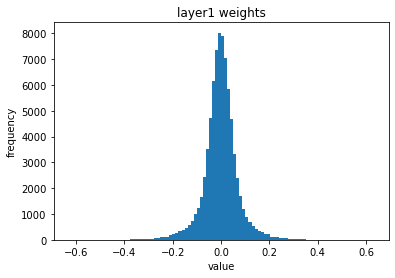

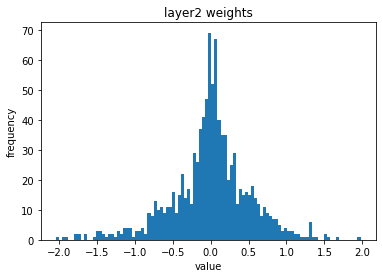

<Figure size 432x288 with 0 Axes>

In [24]:
# 参数可视化 
# 可视化每层的网络参数
layer1_weights = model.weights[1].flatten().tolist()
plt.hist(layer1_weights, bins=100)
plt.title("layer1 weights")
plt.xlabel("value")
plt.ylabel("frequency")
plt.show()
plt.savefig("Vis/Layer1_Weight.png")

layer2_weights = model.weights[2].flatten().tolist()
plt.hist(layer2_weights, bins=100)
plt.title("layer2 weights")
plt.xlabel("value")
plt.ylabel("frequency")
plt.show()
plt.savefig("Vis/Layer2_Weight.png")

In [23]:
print(pd.DataFrame(model.biases[1]))
print(pd.DataFrame(model.biases[2]))

           0
0  -1.466652
1   1.097910
2  -0.744193
3   0.884394
4   0.606597
..       ...
95 -1.820702
96  0.582236
97 -0.179390
98 -1.293654
99  0.125106

[100 rows x 1 columns]
          0
0  1.074971
1 -2.175137
2  0.270846
3 -1.406566
4 -0.429944
5  0.759697
6  0.674167
7  0.025598
8  2.650121
9  0.262419


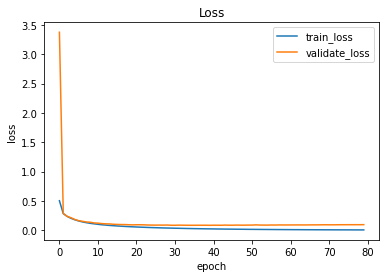

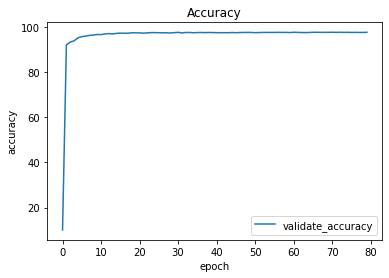

In [25]:
# loss曲线
log[['train_loss','validate_loss']].plot(title='Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
#plt.savefig("Vis/loss.png")
#     plt.close()

# accuracy曲线
log[['validate_accuracy']].plot(title='Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()
#plt.savefig("Vis/Accuracy.png")

## 测试

In [26]:
res = []
for test_X, label in test_data:
    output = model.forward(test_X)
    res.append(np.argmax(output) == np.argmax(label))
accuracy = sum(res) / 100.0
print(f"Test accuracy {accuracy} %.")

Test accuracy 97.54 %.
